# Part 3 

## Model 1 - Base model 

In [41]:
import os
import numpy as np
from torchvision import transforms
from medmnist import OCTMNIST
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

In [42]:
# Import lr_scheduler from torch.optim
from torch.optim import lr_scheduler

# Define the data directory where the dataset will be downloaded
data_dir = './datanew'

# Create a directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download and load the OCTMNIST dataset
dataset = OCTMNIST(root=data_dir, split='train', download=True, transform=transforms.ToTensor())

dataset

Using downloaded and verified file: ./datanew/octmnist.npz


Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: ./datanew
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [43]:
# Preprocess the dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        label = torch.tensor(label).long().squeeze()  # Convert label to tensor and squeeze to ensure one-dimensional tensor
        return img, label

In [44]:
# Split the dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
epochs = 20
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply transforms and create data loaders
train_loader = DataLoader(CustomDataset(train_dataset), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset(val_dataset), batch_size=64, shuffle=False)
test_loader = DataLoader(CustomDataset(test_dataset), batch_size=64, shuffle=False)

# Print the sizes of individual splits
print("Size of train dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of test dataset:", len(test_dataset))

Size of train dataset: 68233
Size of validation dataset: 14621
Size of test dataset: 14623


In [45]:
# Define the neural network model

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)  # Changed output to 4 classes for OCTMNIST dataset

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model, loss function, and optimizer
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [46]:
# Define the training function
def train_model_simple(model, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        scheduler.step(val_losses[-1])

        print()

    print(f"Best validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs


# Create the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # No weight decay

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
print("Training simple CNN model")
# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model_simple(model, criterion, optimizer, scheduler, num_epochs=epochs)

# Save the best model weights
torch.save(model.state_dict(), 'best_model1.pth')
print("Best model saved.")

Training simple CNN model
Epoch 1/20
----------


/user/gwalke/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train Loss: 0.7767 Acc: 0.7082
Val Loss: 0.5737 Acc: 0.7930

Epoch 2/20
----------
Train Loss: 0.5242 Acc: 0.8143
Val Loss: 0.4870 Acc: 0.8249

Epoch 3/20
----------
Train Loss: 0.4600 Acc: 0.8365
Val Loss: 0.4975 Acc: 0.8233

Epoch 4/20
----------
Train Loss: 0.4235 Acc: 0.8493
Val Loss: 0.4300 Acc: 0.8449

Epoch 5/20
----------
Train Loss: 0.3907 Acc: 0.8599
Val Loss: 0.4008 Acc: 0.8581

Epoch 6/20
----------
Train Loss: 0.3655 Acc: 0.8677
Val Loss: 0.4274 Acc: 0.8494

Epoch 7/20
----------
Train Loss: 0.3459 Acc: 0.8769
Val Loss: 0.3614 Acc: 0.8698

Epoch 8/20
----------
Train Loss: 0.3306 Acc: 0.8812
Val Loss: 0.3558 Acc: 0.8750

Epoch 9/20
----------
Train Loss: 0.3119 Acc: 0.8886
Val Loss: 0.3521 Acc: 0.8776

Epoch 10/20
----------
Train Loss: 0.2979 Acc: 0.8931
Val Loss: 0.3357 Acc: 0.8798

Epoch 11/20
----------
Train Loss: 0.2851 Acc: 0.8979
Val Loss: 0.3358 Acc: 0.8828

Epoch 12/20
----------
Train Loss: 0.2706 Acc: 0.9047
Val Loss: 0.3388 Acc: 0.8828

Epoch 13/20
----------


In [47]:
# Evaluate the model on the test set
model.eval()
test_corrects = 0
test_loss = 0

test_predictions = []
test_true_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_corrects.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8977
Test Loss: 0.3115


In [48]:

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[4717   60  133   91]
 [  74 1308   23  136]
 [ 181   29  488  456]
 [  77   79  157 6614]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5001
           1       0.89      0.85      0.87      1541
           2       0.61      0.42      0.50      1154
           3       0.91      0.95      0.93      6927

    accuracy                           0.90     14623
   macro avg       0.83      0.79      0.81     14623
weighted avg       0.89      0.90      0.89     14623



In [49]:
# Calculate other evaluation metrics
precision = precision_score(test_true_labels, test_predictions, average='macro')
recall = recall_score(test_true_labels, test_predictions, average='macro')
f1 = f1_score(test_true_labels, test_predictions, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.8340, Recall: 0.7924, F1-score: 0.8088


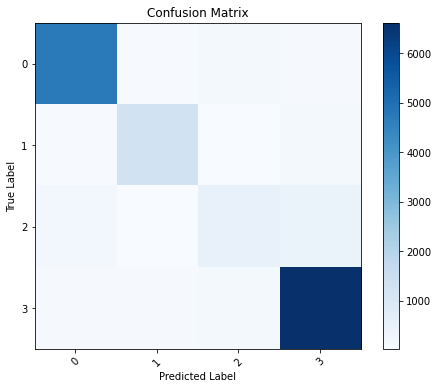

In [50]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(4), ['0','1', '2', '3'], rotation=45)
plt.yticks(range(4), ['0','1', '2', '3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

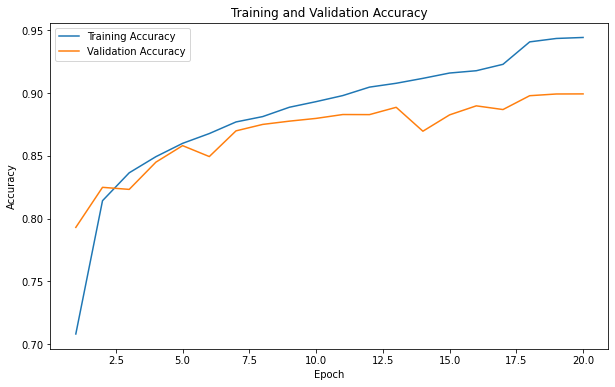

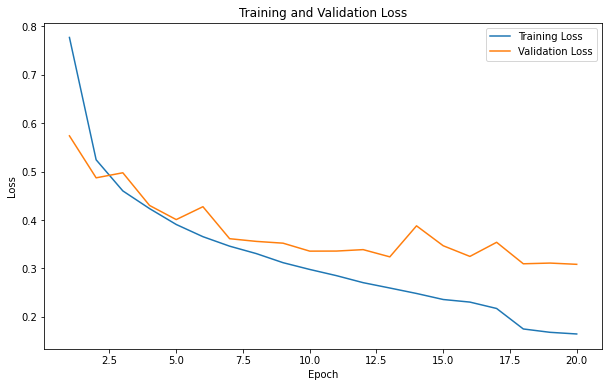

In [51]:
# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model 2 - Added regularization 

In [52]:
# Import lr_scheduler from torch.optim
from torch.optim import lr_scheduler

In [53]:
# Define the neural network model
class CNNwRegularization(nn.Module):
    def __init__(self):
        super(CNNwRegularization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)  # 4 classes for OCTMNIST dataset

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNNwRegularization()
model

CNNwRegularization(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [54]:
# Create the model, loss function, and optimizer with weight decay for L2 regularization
model = CNNwRegularization()
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5  # weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/user/gwalke/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [55]:
# Define the training function
def train_model_CNNwRegularization(model, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        scheduler.step(val_losses[-1])

        print()

    print(f"Best validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

In [56]:
# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model_CNNwRegularization(model, criterion, optimizer, scheduler, num_epochs=epochs)

# Save the best model weights
torch.save(model.state_dict(), 'best_model2.pth')
print("Best model saved.")

Epoch 1/20
----------
Train Loss: 0.7560 Acc: 0.7209
Val Loss: 0.6267 Acc: 0.7790

Epoch 2/20
----------
Train Loss: 0.5144 Acc: 0.8176
Val Loss: 0.5711 Acc: 0.8021

Epoch 3/20
----------
Train Loss: 0.4395 Acc: 0.8431
Val Loss: 0.4311 Acc: 0.8470

Epoch 4/20
----------
Train Loss: 0.4016 Acc: 0.8574
Val Loss: 0.4004 Acc: 0.8581

Epoch 5/20
----------
Train Loss: 0.3713 Acc: 0.8676
Val Loss: 0.3897 Acc: 0.8615

Epoch 6/20
----------
Train Loss: 0.3482 Acc: 0.8756
Val Loss: 0.3815 Acc: 0.8656

Epoch 7/20
----------
Train Loss: 0.3266 Acc: 0.8846
Val Loss: 0.3465 Acc: 0.8790

Epoch 8/20
----------
Train Loss: 0.3112 Acc: 0.8903
Val Loss: 0.3788 Acc: 0.8657

Epoch 9/20
----------
Train Loss: 0.2934 Acc: 0.8968
Val Loss: 0.3292 Acc: 0.8865

Epoch 10/20
----------
Train Loss: 0.2778 Acc: 0.9015
Val Loss: 0.3342 Acc: 0.8861

Epoch 11/20
----------
Train Loss: 0.2614 Acc: 0.9078
Val Loss: 0.3197 Acc: 0.8932

Epoch 12/20
----------
Train Loss: 0.2474 Acc: 0.9133
Val Loss: 0.3368 Acc: 0.8860

E

In [57]:
model.eval()
test_corrects = 0
test_loss = 0

test_predictions = []
test_true_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_corrects.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8973
Test Loss: 0.3245


In [58]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[4723   95  110   73]
 [  65 1330   18  128]
 [ 199   37  514  404]
 [  76   95  202 6554]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5001
           1       0.85      0.86      0.86      1541
           2       0.61      0.45      0.51      1154
           3       0.92      0.95      0.93      6927

    accuracy                           0.90     14623
   macro avg       0.83      0.80      0.81     14623
weighted avg       0.89      0.90      0.89     14623



In [59]:
# Calculate other evaluation metrics
precision = precision_score(test_true_labels, test_predictions, average='macro')
recall = recall_score(test_true_labels, test_predictions, average='macro')
f1 = f1_score(test_true_labels, test_predictions, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.8279, Recall: 0.7998, F1-score: 0.8106


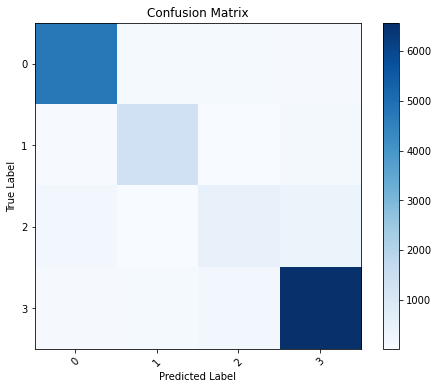

In [60]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(4), ['0','1', '2', '3'], rotation=45)
plt.yticks(range(4), ['0','1', '2', '3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

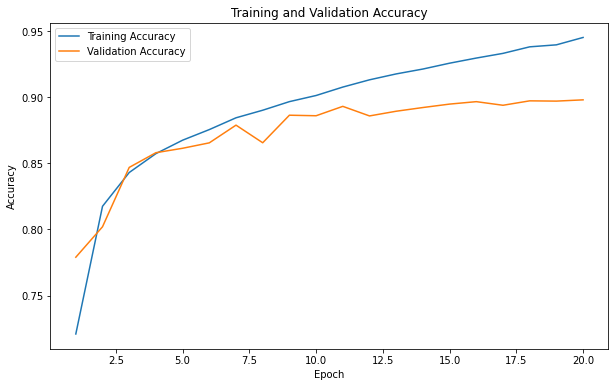

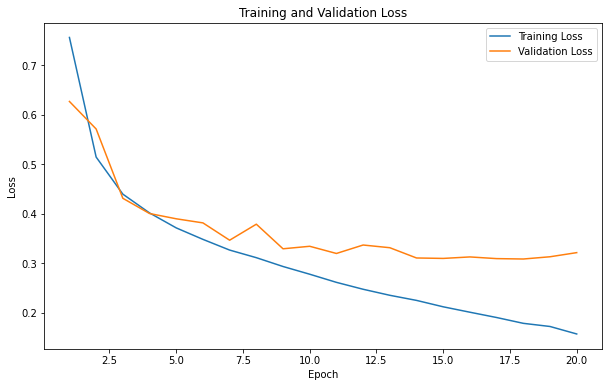

In [61]:
# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model 3 - Added dropout 

In [62]:
# Define the neural network model
class CNN_regularization_dropout(nn.Module):
    def __init__(self):
        super(CNN_regularization_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout with a probability of 0.5
        self.fc2 = nn.Linear(128, 4)  #4 classes for OCTMNIST dataset

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

In [63]:
# Create the model, loss function, and optimizer with weight decay for L2 regularization
model = CNN_regularization_dropout()
model

CNN_regularization_dropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [64]:
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5  # l2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/user/gwalke/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [65]:
# Define the training function
def train_model_CNN_regularization_dropout(model, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        scheduler.step(val_losses[-1])

        print()

    print(f"Best validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model_CNN_regularization_dropout(model, criterion, optimizer, scheduler, num_epochs=epochs)

Epoch 1/20
----------
Train Loss: 0.7889 Acc: 0.7110
Val Loss: 0.5939 Acc: 0.7859

Epoch 2/20
----------
Train Loss: 0.5756 Acc: 0.8011
Val Loss: 0.5110 Acc: 0.8177

Epoch 3/20
----------
Train Loss: 0.5103 Acc: 0.8243
Val Loss: 0.4494 Acc: 0.8396

Epoch 4/20
----------
Train Loss: 0.4696 Acc: 0.8395
Val Loss: 0.4368 Acc: 0.8447

Epoch 5/20
----------
Train Loss: 0.4331 Acc: 0.8509
Val Loss: 0.4064 Acc: 0.8564

Epoch 6/20
----------
Train Loss: 0.4108 Acc: 0.8572
Val Loss: 0.4119 Acc: 0.8581

Epoch 7/20
----------
Train Loss: 0.3900 Acc: 0.8634
Val Loss: 0.3668 Acc: 0.8692

Epoch 8/20
----------
Train Loss: 0.3745 Acc: 0.8684
Val Loss: 0.3695 Acc: 0.8671

Epoch 9/20
----------
Train Loss: 0.3596 Acc: 0.8747
Val Loss: 0.3485 Acc: 0.8770

Epoch 10/20
----------
Train Loss: 0.3477 Acc: 0.8786
Val Loss: 0.3439 Acc: 0.8791

Epoch 11/20
----------
Train Loss: 0.3333 Acc: 0.8826
Val Loss: 0.3601 Acc: 0.8750

Epoch 12/20
----------
Train Loss: 0.3228 Acc: 0.8857
Val Loss: 0.3312 Acc: 0.8840

E

In [66]:
# Save the best model weights
torch.save(model.state_dict(), 'best_model3.pth')
print("Best model saved.")

model.eval()
test_corrects = 0
test_loss = 0

test_predictions = []
test_true_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_corrects.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Best model saved.
Test Accuracy: 0.8959
Test Loss: 0.2949


In [67]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[4758   67   88   88]
 [  73 1287   15  166]
 [ 223   22  389  520]
 [  89   57  114 6667]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5001
           1       0.90      0.84      0.87      1541
           2       0.64      0.34      0.44      1154
           3       0.90      0.96      0.93      6927

    accuracy                           0.90     14623
   macro avg       0.84      0.77      0.79     14623
weighted avg       0.89      0.90      0.89     14623



In [68]:
# Calculate other evaluation metrics
precision = precision_score(test_true_labels, test_predictions, average='macro')
recall = recall_score(test_true_labels, test_predictions, average='macro')
f1 = f1_score(test_true_labels, test_predictions, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.8403, Recall: 0.7715, F1-score: 0.7934


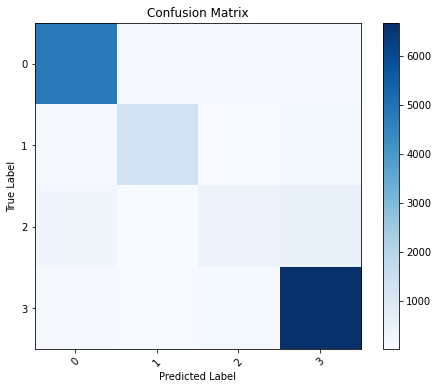

In [69]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(4), ['0','1', '2', '3'], rotation=45)
plt.yticks(range(4), ['0','1', '2', '3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

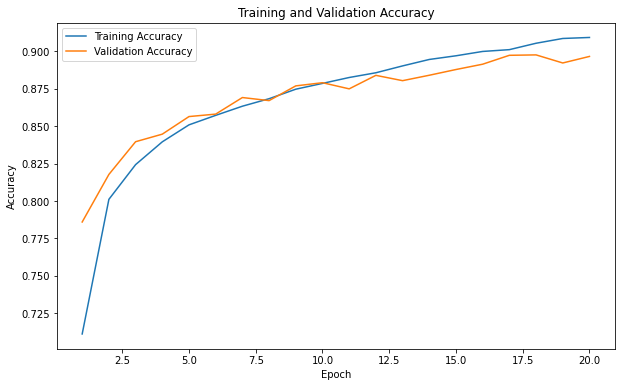

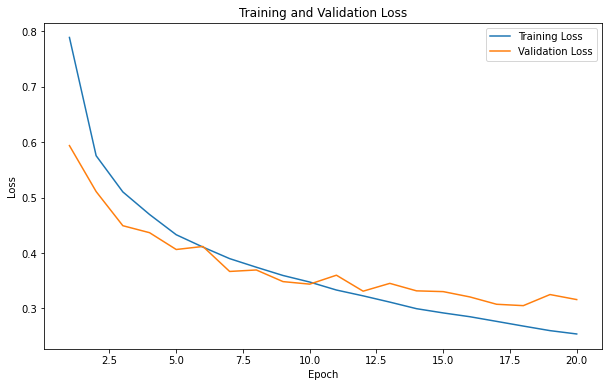

In [70]:
# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Model 4 - Added early stopping  

In [71]:
# Define the neural network model
class CNN_regularization_dropout_early(nn.Module):
    def __init__(self):
        super(CNN_regularization_dropout_early, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout with a probability of 0.5
        self.fc2 = nn.Linear(128, 4)  # 4 classes for OCTMNIST dataset

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

In [72]:
# Create the model, loss function, and optimizer with weight decay for L2 regularization
model = CNN_regularization_dropout_early()
model

CNN_regularization_dropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [73]:
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5  # Adjust the value as needed
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/user/gwalke/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [74]:
# Define the training function
def train_model_CNN_regularization_dropout_early(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf')
    no_improve_count = 0  # Counter to track the number of epochs without improvement

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improve_count = 0
                else:
                    no_improve_count += 1

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        scheduler.step(val_losses[-1])

        if no_improve_count >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            break

        print()

    print(f"Best validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

In [75]:
# Train the model with early stopping based on validation loss
model, train_losses, val_losses, train_accs, val_accs = train_model_CNN_regularization_dropout_early(model, criterion, optimizer, scheduler, num_epochs=epochs, patience=3)

# Save the best model weights
torch.save(model.state_dict(), 'best_model4.pth')
print("Best model saved.")

Epoch 1/20
----------
Train Loss: 0.8107 Acc: 0.7012
Val Loss: 0.5964 Acc: 0.7850

Epoch 2/20
----------
Train Loss: 0.5716 Acc: 0.8018
Val Loss: 0.5152 Acc: 0.8148

Epoch 3/20
----------
Train Loss: 0.5104 Acc: 0.8245
Val Loss: 0.4569 Acc: 0.8361

Epoch 4/20
----------
Train Loss: 0.4690 Acc: 0.8388
Val Loss: 0.4302 Acc: 0.8461

Epoch 5/20
----------
Train Loss: 0.4403 Acc: 0.8468
Val Loss: 0.4102 Acc: 0.8548

Epoch 6/20
----------
Train Loss: 0.4235 Acc: 0.8538
Val Loss: 0.3809 Acc: 0.8657

Epoch 7/20
----------
Train Loss: 0.4029 Acc: 0.8594
Val Loss: 0.3771 Acc: 0.8664

Epoch 8/20
----------
Train Loss: 0.3911 Acc: 0.8644
Val Loss: 0.4142 Acc: 0.8523

Epoch 9/20
----------
Train Loss: 0.3770 Acc: 0.8691
Val Loss: 0.3503 Acc: 0.8748

Epoch 10/20
----------
Train Loss: 0.3644 Acc: 0.8734
Val Loss: 0.3938 Acc: 0.8631

Epoch 11/20
----------
Train Loss: 0.3553 Acc: 0.8762
Val Loss: 0.3516 Acc: 0.8779

Epoch 12/20
----------
Train Loss: 0.3461 Acc: 0.8797
Val Loss: 0.3580 Acc: 0.8721
No

In [76]:
# Evaluate the model on the test set
model.eval()
test_corrects = 0
test_loss = 0

test_predictions = []
test_true_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_corrects.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8753
Test Loss: 0.3446


In [77]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[4744   70   54  133]
 [ 112 1222    3  204]
 [ 278   33  141  702]
 [ 128   69   37 6693]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      5001
           1       0.88      0.79      0.83      1541
           2       0.60      0.12      0.20      1154
           3       0.87      0.97      0.91      6927

    accuracy                           0.88     14623
   macro avg       0.81      0.71      0.72     14623
weighted avg       0.86      0.88      0.85     14623



In [78]:
# Calculate other evaluation metrics
precision = precision_score(test_true_labels, test_predictions, average='macro')
recall = recall_score(test_true_labels, test_predictions, average='macro')
f1 = f1_score(test_true_labels, test_predictions, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.8109, Recall: 0.7075, F1-score: 0.7183


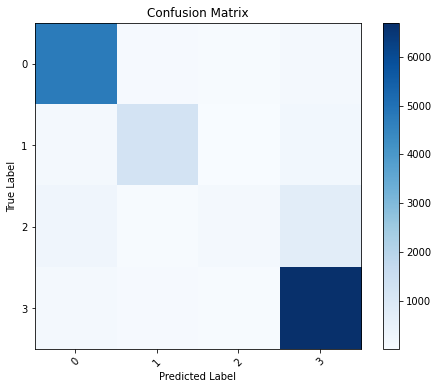

In [79]:
# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(4), ['0','1', '2', '3'], rotation=45)
plt.yticks(range(4), ['0','1', '2', '3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

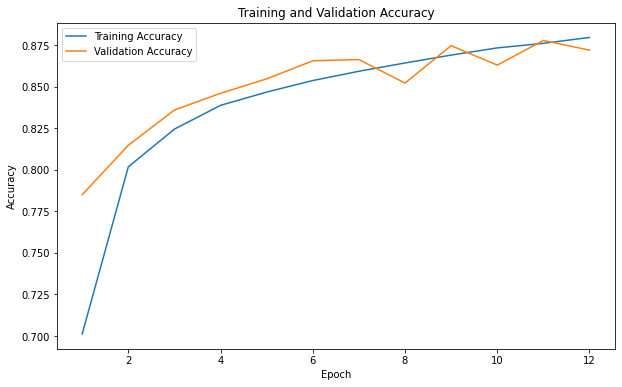

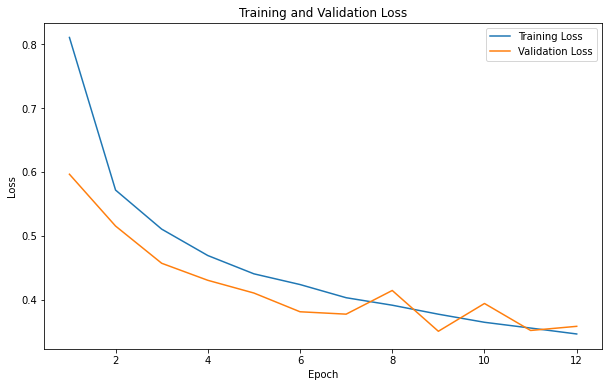

In [80]:
# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()